# Uncertainty Estimation for impact assessment

This notebook is based on:

Berends, K.D., Warmink, J.J., Hulscher, S.J.M.H., 2018, Efficient uncertainty quantification for impact analysis of human interventions in rivers, Environmental Modelling & Software 107, 50-58. doi: https://doi.org/10.1016/j.envsoft.2018.05.021

## What are we trying to do?

In this notebook we consider the following scenario. As a civil (river) engineer, to reduce flood risk we are tasked with designing a change to the river system that lowers water levels during a given design discharge. An example of such changes can be digging new channels, removing existing obstacles to flow, etc.

A key parameter in open channel flow dynamics is 'hydraulic roughness', which is commonly modelled by empirical formulas that take several parameters such as vegetation density and grain size. In most cases, these parameters cannot be directly or precisely measured. Our approach is to assume these parameters are 'uncertain', which means that we are modelling them not as discrete values (like 1 or 2.4) but as probability density functions. 

Our task is to give an estimate of the impact of our proposed intervention in terms of water level decrease. 


## Load and visualise model output

First we will load example testdata and plot the distributions. 

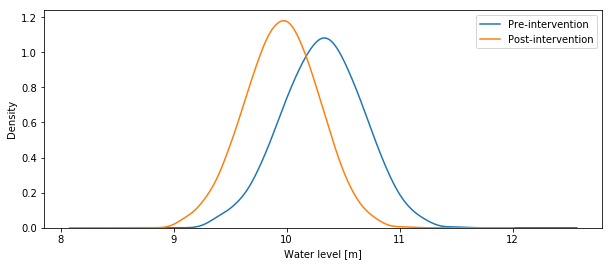

In [2]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt 
from coral import testdata

# We set subsample to false, since we will generate our own subsample later on
predictor, response = testdata.linear_univariable(ss=False)

# Both datasets are Pandas DataFrames
fig, ax = plt.subplots(1, figsize=(10, 4))
predictor.plot(kind='kde', ax=ax, label="Pre-intervention")
response.plot(kind='kde', ax=ax, label="Post-intervention")

ax.legend()
ax.set_ylim([0, ax.get_ylim()[1]])
ax.set_xlabel('Water level [m]')
plt.show()


These testdata are the results of a Monte Carlo simulation with two models: one reference model (pre-intervention) and one model after our proposed intervention (post-intervention). The actual water levels after the intervention are, on average, lower than before. That's good: we are lowering flood water levels. But by how much?

<div class="alert alert-block alert-info">
**Background information** 
Subtracting stochastic variables is not as straightforward as subtracting regular (deterministic) variables. What is important to note here is that the pre-intervention and post-intervention models will have `correlated output`. Statistically speaking, they are not independent. Let's take a small sidestep to see what that means. Suppose we have two normally distributed variables $X$ and $Y$, than the difference $Z$ is given as:

$Z = \mathcal{N}(\mu_y - \mu_x, \sigma^2_y + \sigma^2_x)$

Which means that the variance will increase if we take the difference. For significant uncertainty in $X$ and $Y$, this means that the effect $Z$ will be *very uncertain*. However, in our case the variables are not independent. If we introduce linear correlation depending only on the correlation coefficient $\rho$ such that $\rho = \frac{\sigma_{xy}}{\sigma_x\sigma_y}$, the difference is:

$Z = \mathcal{N}(\mu_y - \mu_x, \sigma^2_y + \sigma^2_x - 2\sigma_{xy})$

where $\sigma_{xy}$ is the covariance. Taking into account the covariance is important. For our case, we do not really have to know the covariance, since we took care of any corralation in the sampling. See the reference paper for more information. 
</div>

To calculate the effect we simply subtract:


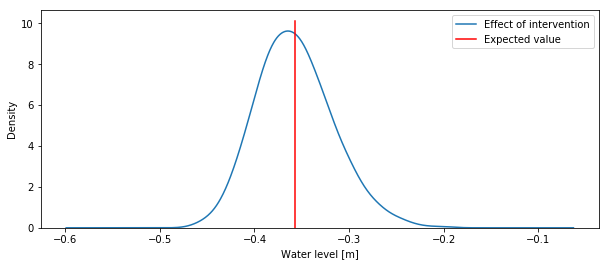

Expected effect: -0.36 
Standard deviation: 0.04 m


In [3]:
# Simply subtract the two matrices to compute the impact
effect = response - predictor


# Plot results
fig, ax = plt.subplots(1, figsize=(10, 4))
effect.plot(kind='kde', ax=ax, label="Effect of intervention")
ax.plot([effect.mean()] * 2, ax.get_ylim(), '-r', label='Expected value')
ax.legend()
ax.set_ylim([0, ax.get_ylim()[1]])
ax.set_xlabel('Water level [m]')
plt.show()

print ("Expected effect: {:.2f} \nStandard deviation: {:.2f} m".format(effect.mean(), effect.std()))


We observe that based on our Monte Carlo experiment, we expect a water level decrease of 36 cm and a standard deviation of 4 cm. We also see that the effect is not normally distributed, but is skewed to the left. 

## Approximate the effect


We cannot always afford to do Monte Carlo simulation with multiple models. This is where `coral` comes in: if the two models $X$ and $Y$ are sufficiently correlated, we only need one variable (e.g. $X$) and the correlation function to estimate $Y$. Let's apply this to our model output:

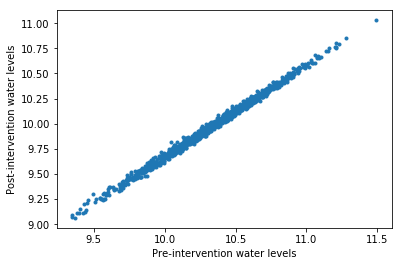

In [4]:
fig, ax = plt.subplots(1)
ax.plot(predictor, response, '.')
ax.set_xlabel('Pre-intervention water levels')
ax.set_ylabel('Post-intervention water levels')
plt.show()

The two variables are very linearly correlated. For impact analysis of river engineer interventions, this turns out to be the case in 1D and 2D hydrodynamic models. We can exploit this as follows. We assume a relationship between the pre and post intervention water levels such that:

$H_{post} = \alpha H_{pre} + \beta + \epsilon$, where $\epsilon \sim \mathcal{N}(0, \sigma_\epsilon)$ 

If we know the value of the unknown parameters $(\alpha, \beta, \sigma_\epsilon)$ and $H_{pre}$, we can compute $H_{post}$. We are going to do this as follows:

1. We draw a subsample of $H_{pre}$. We only evaluate the model for this subsample
2. Based on the subsample we estimate the correlation function via Bayesian inference
3. We estimate $H_{post}$

### (1) Draw subsample

First, we draw a subsample from the predictor (the pre-intervention model). We have done a full Monte Carlo simulation with the predictor, but don't want to do Monte Carlo simulation with the response (post-intervention model). By default, we use stratified subsampling:


In [5]:
from coral.sample import subsample

ss, path_ss, path_bins = subsample(predictor, subsample_size=20);

# print subsample indices
print (ss)

No values in bin [11.279866847275 - 11.3873022423375], or bin already filled
SUBSAMPLE SAVED TO d:\PhD\rivercare\src\coral\docs\notebooks/subsample.csv
[767 191 339 503 779  19  46 734  45 650 434  25 248 124 740 692 148 916
  84]


The subsample is a list of indices from from the predictor ensemble. This list has to be evaluated with the post-intervention model. Here we already have the full enseble, so we're going to fake this:

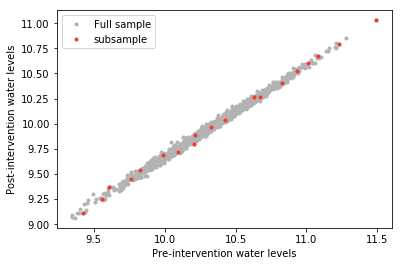

In [6]:
# Make a copy of the predictor dataframe, but nan values everywhere
ss_response = predictor.copy()
ss_response.iloc[:] = np.nan

# Fill subsample positions with data (from our 'model runs')
for i in ss:
    ss_response.iloc[i] = response.iloc[i]
    
# Plot subsample vs full sample
fig, ax = plt.subplots(1)
ax.plot(predictor, response, '.', color=(0.7, 0.7, 0.7), label='Full sample')
ax.plot(predictor, ss_response, '.', color=(1.0, 0.2, 0.2), label='subsample')
ax.set_xlabel('Pre-intervention water levels')
ax.set_ylabel('Post-intervention water levels')
ax.legend()
plt.show()

### (2) Estimate correlation function

Since we only have a (very) limited sample, any model we infer from this will be uncertain. This is called ``model uncertainty``, which expresses that we cannot precisely infer the regression parameters $(\alpha, \beta, \sigma_\epsilon)$. On top of this, the model itself is 'uncertain' as well because of the stochastic term $\epsilon$. This is called ``predictive uncertainty``. Note that model uncertainty could be reduced by increasing the subsample size, but the predictive uncertainty can not. 

<div class="alert alert-block alert-info">
It is important to get good estimates of both the model and predictive uncertainty. The model uncertainty is unavoidable because of the limited subsample size; this will be our measure for the accuracy of our estimation vs. full Monte Carlo integration. The predictive uncertainty is fundamental to impact analysis. Here, it can be interpreted as a measure for the 'likeliness' of the post-intervention model state compared to the pre-intervention state. 
</div>

We use Bayesian linear regression to estimate all parameters. 

Note: progress bar do not show up in Notebook for some reason so the process may seem to be stuck while it is not. 

2018-11-12 09:22:23 - utils.py - INFO - Start logging to d:\PhD\rivercare\src\coral\docs\notebooks\log.log
2018-11-12 09:22:23 - analysis.py - INFO - Parameter values 
outputpath: d:\PhD\rivercare\src\coral\docs\notebooks
statmodel: <function general_linear at 0x000000000F910C80>
inference: mcmc
ppc_draws: 100
logtransform: True
origintransform: True
draws: 10000
burn_in: 5000
cores: 2
chains: 2
confidence_interval: 95
tracesumpath: d:\PhD\rivercare\src\coral\docs\notebooks
name: noname

2018-11-12 09:22:23 - analysis.py - INFO - Subsample size is 19
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Slope, Intercept, sigma_log__]


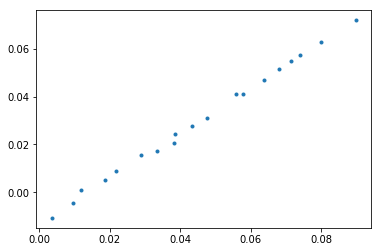

In [8]:
from coral import analysis
from coral import reglib
from importlib import reload
reload(analysis)


parameters = dict(outputpath=os.getcwd(),
                  ppc_draws=100,
                  logtransform=True,
                  origintransform=True,
                  statmodel=reglib.general_linear,
                  inference='mcmc')
                  
results = analysis.uncertainty_estimation(predictor, response, ss, **parameters)

The output is a ``RegressionResult`` object. The output may be inspected or written to a NetCDF output file:

In [22]:
results.save_to_file("Test.nc")

Full sample size: 1000
Subsample size: 19
 Locations: 1
 Posterior draws:10000
RESPMMOD: (10000, 1000)


## Visualise the results

The first step is to inspect the regression results. This is an important visual check to confirm that our statistical model describes the data. 

In [ ]:
# ToDO; add regression result viz

Next, let's take a look at the output cumulative density distribution of the predictor ($H_{pre}$) and the modelled response ($\hat{H}_{post}$). For this testcase, we have a full Monte Carlo ensemble of the post-intervention model output . 

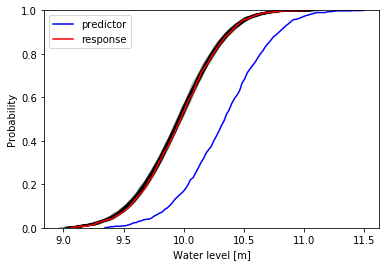

In [41]:
from coral import statsfunc

p, cdf_pred = statsfunc.get_empirical_cdf(results.predictor)
p, cdf_resp = statsfunc.get_empirical_cdf(results.response)

fig, ax = plt.subplots(1)

for i in range(2000, 10000, 100):
    p, cdf_respm = statsfunc.get_empirical_cdf(results.response_modelled[i])
    ax.plot(cdf_respm, p,  color='k', alpha=0.2);

ax.plot(cdf_pred, p,  color='b', label='predictor');
ax.plot(cdf_resp, p,  color='r', label='response');

ax.set_xlabel ('Water level [m]')
ax.set_ylabel ('Probability')
ax.set_ylim((0, 1))
ax.legend()
plt.show()


As we can see, the modelled responses are close to the actual response. 